<a href="https://colab.research.google.com/github/sm354/COL870-Assignment-1/blob/main/2_1_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# !pip install seqeval

     |████████████████████████████████| 51kB 4.4MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp37-none-any.whl size=16172 sha256=0aa636c45a8d8232070f4b6fabd59bd67cef284dafc7016a527b918f3a9b1945
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built seqeval


In [4]:
experiment_name = "ner_char_glove"
pretrained = "glove" # glove or random

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
from torch.utils.data import Dataset, DataLoader, TensorDataset
import io
import sklearn
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import seqeval
from seqeval.metrics import accuracy_score as seq_accuracy_score
from seqeval.metrics import classification_report as seq_classification_report
from seqeval.metrics import f1_score as seq_f1_score


if torch.cuda.is_available():  
  device = "cuda:0" 
else:  
  device = "cpu"  


'''Helper Functions'''
# reading text file in python and making list of sentences (list of lists) and list of tags(list of lists)
def load_data(datapath, buildvocab_tags= True, vocab = None, nertags = None):
    if(buildvocab_tags == True):
        all_words = []
        all_tags = []
        with open(datapath) as f:
            lines = f.readlines()
            sent_num = 0
            for line in lines[1:]: #1: so that the first blank line isn't taken into account
                if(line == "\n"):
                    sent_num+=1
                else:
                    line_sep = line.split(sep = " ")
                    all_words.append(line_sep[0])
                    all_tags.append(line_sep[3][:-1])
                    
        words = list(set(all_words))
        tags = list(set(all_tags))

        vocab = {}
        vocab['<pad>'] = 0 # for padding input sequences
        vocab['<oov>'] = 1
        for i, word in enumerate(words):
            vocab[word] = i+2
            
        nertags = {}
        nertags['padtag'] = 0
        for i,nertag in enumerate(tags):
            nertags[nertag] = i+1

    train_sent = []
    train_tags = []
    with open(datapath) as f:
        lines = f.readlines()
        sent_num = 0
        sentence = []
        tag = []
        for line in lines[1:]: #1: so that the first blank line isn't taken into account
            if(line == "\n"):
                sent_num+=1
                train_sent.append(sentence)
                train_tags.append(tag)
                sentence = []
                tag = []
            else:
                line_sep = line.split(sep = " ")
                if(line_sep[0] in vocab.keys()):
                    sentence.append(vocab[line_sep[0]])
                else:
                    sentence.append(vocab['<oov>'])
                    
                tag.append(nertags[line_sep[3][:-1]])

    # padding the sentences at the end
    seq_maxlen = max(len(x) for x in train_sent)
    x_lengths = [len(x) for x in train_sent]
    Xtrain = []
    Ytrain = []
    for sent, tags in zip(train_sent, train_tags):
        length_toappend = seq_maxlen - len(sent)
        Xtrain.append(sent+[0]*length_toappend)
        Ytrain.append(tags+[0]*length_toappend)


    Xtrain = torch.Tensor(Xtrain)
    Ytrain = torch.Tensor(Ytrain)
    x_lengths = torch.Tensor(x_lengths)
    # print(Xtrain.shape, Ytrain.shape, x_lengths.shape)
    
    return Xtrain, Ytrain, x_lengths, vocab, nertags

def load_char_data(words, charvocab):
    train_char_sent = []
    train_char_label = []
    for word in words:
        chars = []
        char_labels = []

        word_sep = list(word)
        for c in word_sep[:-1]:
            if (c in charvocab.keys()):
                chars.append(charvocab[c])
            else:
                chars.append(charvocab['<oovchar>'])
        for c in word_sep[1:]:
            if (c in charvocab.keys()):
                char_labels.append(charvocab[c])
            else:
                char_labels.append(charvocab['<oovchar>'])
        
        train_char_sent.append(chars)
        train_char_label.append(char_labels)

    # padding the char_sents at the end
    seq_maxlen = max(len(x) for x in train_char_sent)
    x_lengths_char = [len(x) for x in train_char_sent]
    Xtrain_char = []
    Ytrain_char = []
    for char_sent, char_label in zip(train_char_sent, train_char_label):
        length_toappend = seq_maxlen - len(char_sent)
        Xtrain_char.append(char_sent+[0]*length_toappend)
        Ytrain_char.append(char_label+[0]*length_toappend) # 0 is padchar


    Xtrain_char = torch.Tensor(Xtrain_char)
    Ytrain_char = torch.Tensor(Ytrain_char)
    x_lengths_char = torch.Tensor(x_lengths_char)
    # print(Xtrain.shape, Ytrain.shape, x_lengths.shape)
    
    return Xtrain_char, Ytrain_char, x_lengths_char

def pad_chars(topadlist, maxlen):
    topadlist = topadlist + [0]*(maxlen-len(topadlist))

    return topadlist

def make_id2word_charvocab(vocab, charvocab):
    max_charlen = max(len(word) for word in vocab.keys())
    print(max_charlen)
    word_charlevel_vocab = {}
    wordid2wordlen = {}
    for word in vocab.keys():
        word_charlevel_vocab[vocab[word]] = [charvocab[w] if w in charvocab.keys() else charvocab['<oovchar>'] for w in word]
        word_charlevel_vocab[vocab[word]] = pad_chars(word_charlevel_vocab[vocab[word]], max_charlen)

        wordid2wordlen[vocab[word]] = len(word)
        # word_charlevel_vocab[vocab[word]] = word_charlevel_vocab[vocab[word]].extend([charvocab['<padchar>']]*(max_charlen-len(word_charlevel_vocab[vocab[word]])))
    return word_charlevel_vocab, wordid2wordlen


def load_char_level(X, wordid2word_charlevel_vocab, wordid2wordlen):
    #X is of shape (no.of.sentences, 104)
    Xcharlevel = [] # will finally be fo shape (total.sentences, max_sent.len, )
    Xcharlevel_lengths = []
    for i in range(X.shape[0]):
        sentence = []
        wordlengths = []
        for j in range(X.shape[1]):
            sentence.append(torch.tensor([wordid2word_charlevel_vocab[int(X[i, j].item())]]))
            wordlengths.append(wordid2wordlen[int(X[i, j].item())])
            # sentences = pad_sequence(sentences)
        # print(i)
        Xcharlevel_lengths.append(wordlengths)
        Xcharlevel.append(torch.stack(sentence))
    
    return torch.squeeze(torch.stack(Xcharlevel)), torch.tensor(Xcharlevel_lengths)

def get_charvocab(vocab):
    # using vocab make charvocab
    words = list(vocab.keys())
    characters = [char for word in words for char in word]
    characters = list(set(characters))
    char_vocab = {}
    char_vocab["<padchar>"] = 0
    char_vocab["<oovchar>"] = 1
    for i, char in enumerate(characters):
        char_vocab[char] = i+2

    return char_vocab

### Training Data
### using dataloader to make data batches

In [5]:
traindatapath = "/content/drive/MyDrive/Q2_DL/train.txt"
devdatapath = "/content/drive/MyDrive/Q2_DL/dev.txt"

Xtrain, Ytrain, x_trainlengths, vocab, nertags = load_data(traindatapath, buildvocab_tags=True)
Xdev, Ydev, x_devlengths, _, _ = load_data(devdatapath, buildvocab_tags=False, vocab = vocab, nertags = nertags)


In [6]:
# Character Level training data making
# make vocabulary of characters from train vocabulary
char_vocab = get_charvocab(vocab)
wordid2word_charlevel_vocab, wordid2wordlen = make_id2word_charvocab(vocab, char_vocab) # of the form {word:[1,2,3,4]}, {wordnum:wordlen}
#make char level train data for the char embeddings 
Xtrain_char, xlength_char = load_char_level(Xtrain, wordid2word_charlevel_vocab, wordid2wordlen)
#finally make the dataloader for train
traindataset = TensorDataset(Xtrain, Xtrain_char, Ytrain, x_trainlengths, xlength_char)
Trainloader = DataLoader(traindataset, batch_size= 128, shuffle=True)


# Character Level validation data making
Xdev_temp, Ydev_temp, x_devlengths_temp, devvocab, devnertags = load_data(devdatapath, buildvocab_tags=True)
wordid2word_charlevel_vocab_dev, wordid2wordlen_dev = make_id2word_charvocab(devvocab, char_vocab) # of the form {word:[1,2,3,4]}, {wordnum:wordlen}
#make char level train data for the char embeddings 
Xdev_char, xdevlength_char = load_char_level(Xdev_temp, wordid2word_charlevel_vocab_dev, wordid2wordlen_dev)
#finally make the dataloader for train
devdataset = TensorDataset(Xdev, Xdev_char, Ydev, x_devlengths, xdevlength_char)
Devloader = DataLoader(devdataset, batch_size= 128, shuffle=True)

64
26


In [7]:
embedding_size = 100
if(pretrained == "glove"):
    gloveembeddings_index = {}
    with io.open("/content/drive/MyDrive/Q2_DL/glove.6B.100d.txt", encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:],dtype='float32')
            gloveembeddings_index[word] = coefs

    #using vocab and Xtrain, Xvalid, get pretrained glove word embeddings
    glove_embeds = np.zeros((len(vocab), embedding_size))
    for word in vocab.keys():
        if(word in gloveembeddings_index.keys()):
            # for the pad word let theembedding be all zeros
            glove_embeds[vocab[word]] = gloveembeddings_index[word]
        else:
            glove_embeds[vocab[word]] = np.random.randn(embedding_size)
    word_embeds = torch.Tensor(glove_embeds)
    # print(glove_embeds.shape) # shape (vocablength , embedding dim)

if(pretrained == "random"):
    num_words = len(vocab)
    word_embeds = torch.rand(num_words, embedding_size)

# hence we get word_embeds which we could use afterwards


In [8]:
#weight matrix for cross entropy loss
weight = torch.zeros([len(nertags)])
for i, tag in enumerate(nertags):
    if(tag!='padtag' and tag!='O'):
        weight[i] = 20
    else:
      weight[i] = 1
    # weight[i] = 1/((Ytrain.view(-1) == i).sum())
# print(weight)

In [9]:
char_onehot = torch.eye(len(char_vocab))
imp_classes = [nertags[tag] for tag in nertags.keys()]
imp_classes.remove(nertags['padtag'])
imp_classes.remove(nertags['O'])
# print(len(imp_classes)) #16 classes now for calculating the performance metrics
# print(imp_classes)
# print(char_onehot.type())
print(nertags)

{'padtag': 0, 'I-tim': 1, 'B-org': 2, 'B-per': 3, 'I-per': 4, 'B-tim': 5, 'O': 6, 'I-geo': 7, 'I-org': 8, 'I-gpe': 9, 'B-nat': 10, 'B-art': 11, 'I-art': 12, 'I-eve': 13, 'B-gpe': 14, 'B-eve': 15, 'B-geo': 16, 'I-nat': 17}


# LSTM models for character **level**

In [10]:
class forLSTM(nn.Module):
    def __init__(self, embedding_size, hidden_size, pretr_char_embed):
        super(forLSTM, self).__init__()
        self.charembed = nn.Embedding.from_pretrained(pretr_char_embed, freeze = True) #size of pretrained = (totalchars,embedding size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, bidirectional = True, batch_first = True)

    def forward(self, xchar, xlength_char):
        #xchar is of shape(batchsize, seqlen_maxinbatch, maxwordlen-ie max char = 6)

        shape = xchar.shape
        xchar = xchar.view(-1, shape[2])
        xlength_char = xlength_char.view(-1)
        input = pack_padded_sequence(xchar, xlength_char.cpu(), batch_first=True, enforce_sorted=False)
        input, _ = pad_packed_sequence(input, batch_first=True)
        embed = self.charembed(input)
        _, (h,_) = self.lstm(embed) #h is of size (2, 128*maxno. of words in a sentence in the batch, 25)
        h = h.view(h.shape[1], 50)
        h = h.view(shape[0], shape[1], 50)
        return h

#         out = []
#         for i in range(xchar.shape[1]):
#             input = pack_padded_sequence(xchar[:, i, :], xlength_char[:, i].cpu(), batch_first=True, enforce_sorted=False)
#             input, _ = pad_packed_sequence(input, batch_first=True)
#             embed = self.charembed(input)
#             _, (h,_) = self.lstm(embed)
#             out.append(h) #h is of shape [1, 128, 25]
#         out = torch.stack(out) # out(lhs) is of size [104, 1, 128, 25]
#         out = out.squeeze().permute(1, 0, 2)
#         return out
#         (batchsize, seqlen, embeddingsize = 25)


# class backLSTM(nn.Module):
#     def __init__(self, embedding_size, hidden_size, pretr_char_embed):
#         super(backLSTM, self).__init__()
#         self.charembed = nn.Embedding.from_pretrained(pretr_char_embed, freeze = True) #size of pretrained = (totalchars,embedding size)
#         self.lstm = nn.LSTM(embedding_size, hidden_size, dropout = 0.5, bidirectional = False, batch_first = True)

#     def forward(self, xchar, xlength_char):
#         #xchar is of shape(batchsize, seqlen_maxinbatch, maxwordlen-ie max char = 6)
#         out = []
#         for i in range(xchar.shape[1]):
#             input = pack_padded_sequence(xchar[:, i, :], xlength_char[:, i].cpu(), batch_first=True, enforce_sorted=False)
#             input, _ = pad_packed_sequence(input, batch_first=True)
#             #flip and feed the input into the backlstm
#             input = torch.flip(input, [1]) #flip along the dimension of the maxwordlength
#             embed = self.charembed(input)
#             _, (h,_) = self.lstm(embed)
#             out.append(h) #h is of shape [1, 128, 25]
#         out = torch.stack(out) # out(lhs) is of size [104, 1, 128, 25]
#         out = out.squeeze().permute(1, 0, 2)
#         return out
#         #(batchsize, seqlen, embeddingsize = 25)


# BiLSTM Model

In [37]:
class BiLSTM(nn.Module):
    def __init__(self, embedding_size, hidden_size, total_words, num_class, pretrained = False, pretrained_embed = None, char_embed_size = 0, pretr_char_embed = None):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.wordembed = nn.Embedding.from_pretrained(pretrained_embed, freeze = True)
        self.for_charembed = forLSTM(embedding_size = char_embed_size, hidden_size = 25, pretr_char_embed = pretr_char_embed)
        self.dropout = nn.Dropout(p = 0.5)
        self.bilstm = nn.LSTM(embedding_size + 50,hidden_size, bidirectional = True, batch_first = True)
        self.linear = nn.Linear(2*hidden_size, num_class) # 2 because forward and backward concatenate

    def forward(self, x, xchar, xlengths, xlength_char):
        x = pack_padded_sequence(x, xlengths.cpu(), batch_first=True, enforce_sorted=False)
        x, _ = pad_packed_sequence(x, batch_first=True)

        xlength_char = pack_padded_sequence(xlength_char, xlengths.cpu(), batch_first=True, enforce_sorted=False)
        xlength_char, _ = pad_packed_sequence(xlength_char, batch_first=True, padding_value = len("<pad>")) 
        # above this line padding value is taken as len of pad word becasue that is what we pad sentences 
        # with hance at a character level it should be the length

        xchar = pack_padded_sequence(xchar, xlengths.cpu(), batch_first=True, enforce_sorted=False)
        xchar, _ = pad_packed_sequence(xchar, batch_first=True)

        word_embedding = self.wordembed(x) # x is of size(batchsize, seq_len), wordembed is of size (batchsize, seq_len, embedding_size = 100)
        forwardchar= self.for_charembed(xchar, xlength_char) #forwardchar and backwardchar would be of size (batchsize, seqlen. embedding_size = 25each) 
        word_embedding = torch.cat((word_embedding, forwardchar), dim = 2)

        word_embedding = self.dropout(word_embedding) #dropout
        out, (h,c) = self.bilstm(word_embedding) #'out' has dimension(batchsize, seq_len, 2*hidden_size)

        out = self.linear(out) #now 'out' has dimension(batchsize, seq_len, num_class)
        out = out.view(-1, out.shape[2]) # shape (128*seqlen, 18)
        out = F.log_softmax(out, dim=1) # take the softmax across the dimension num_class, 'out' has dimension(batchsize, seq_len, num_class)
        return out
        
        

In [69]:
model = BiLSTM(embedding_size = 100, hidden_size = 100, total_words = len(vocab), num_class = 18, pretrained = True, pretrained_embed = word_embeds, char_embed_size = len(char_vocab), pretr_char_embed = char_onehot).to(device)
# optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3) 
# lossfunction = nn.CrossEntropyLoss(weight = weight)
lossfunction = nn.CrossEntropyLoss()


# print(model)
def performance(y, ypred, nertags):
    y = y.numpy()
    ypred = ypred.numpy()
    mask = (y != nertags['padtag']) * (y != nertags['O'])
    y = y*mask
    ypred = ypred*mask
    acc = ((y==ypred)*mask).sum()/mask.sum()
    microf1 = f1_score(y, ypred, labels = imp_classes, average='micro')
    macrof1 = f1_score(y, ypred, labels = imp_classes, average='macro')

    return acc, microf1, macrof1

def validate(model, loader):
    with torch.no_grad():
        validloss = 0
        acc = 0
        microf1 = 0
        macrof1 = 0
        i = 0
        for step, (X, Xchar, Y, xlen, xlen_char) in enumerate(loader):
            Y = pack_padded_sequence(Y, xlen, batch_first=True, enforce_sorted=False)
            Y, _ = pad_packed_sequence(Y, batch_first=True)
            ypred = model(X.long().to(device), Xchar.to(device), xlen.to(device), xlen_char.to(device))#.permute(0, 2, 1)
            vloss = lossfunction(ypred.to('cpu'), Y.view(-1).type(torch.LongTensor))
            validloss+=vloss.item()
            acc_, microf1_, macrof1_ = performance(Y.view(-1), torch.argmax(ypred.to('cpu'), dim = 1), nertags)
            acc+=acc_
            microf1 += microf1_
            macrof1 += macrof1_
            i+=1

    return validloss/i, acc/i, microf1/i, macrof1/i

In [70]:
trainlosslist = []
trainacclist = [] #accuracy except pad, O
trainmicrof1list = []
trainmacrof1list = []


validlosslist = []
valacclist = []
valmicrof1list = []
valmacrof1list = []

In [71]:
# optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
# optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)

In [72]:
# Model is ready now we have to train using cross entropy loss
num_epochs = 35
# validloss = []
model.train()
for epoch in range(num_epochs):
    if(epoch == 10):
        model.wordembed.weight.requires_grad = True
    
    totalloss, acc, microf1, macrof1 = 0, 0, 0, 0
    for step, (Xbatch , Xchar ,Ybatch, xbatch_len, xlength_char) in enumerate(Trainloader):
        #make gradients 0
        optimizer.zero_grad()

        Ybatch = pack_padded_sequence(Ybatch, xbatch_len, batch_first=True, enforce_sorted=False)
        Ybatch, y_lengths = pad_packed_sequence(Ybatch, batch_first=True)

        #get output from model and claculate loss
        ypred = model(Xbatch.long().to(device), Xchar.to(device), xbatch_len.to(device), xlength_char.to(device))#.permute(0, 2, 1)
        acc_, microf1_, macrof1_ = performance(Ybatch.view(-1), torch.argmax(ypred.to('cpu'), dim = 1), nertags)
        acc+= acc_
        microf1+=microf1_
        macrof1+=macrof1_
        if(step%20 == 0 and step !=0):
            print("training accuracy = {}, microF1 = {}, macroF1 = {}".format(acc/(step+1), microf1/(step+1), macrof1/(step+1)))
        
        loss = lossfunction(ypred.to('cpu'), Ybatch.view(-1).type(torch.LongTensor)) #Ybatch has dimension (batchsize, seqlen), ypred has dimension(batchsize, num_classes, seqlen)
        totalloss += loss.item()

        #backward and step
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 5) # clip gradient to 5
        optimizer.step()
    
    trainlosslist.append(totalloss/(step+1))
    trainacclist.append(acc/(step+1))
    trainmicrof1list.append(microf1/(step+1))
    trainmacrof1list.append(macrof1/(step+1))

    # model validation loss and scheduler step for learning rate change if required
    val_loss, val_acc, val_microf1, val_macrof1  = validate(model, Devloader)
    validlosslist.append(val_loss)
    valacclist.append(val_acc)
    valmicrof1list.append(val_microf1)
    valmacrof1list.append(val_macrof1)
    
    # scheduler.step(val_loss)
    print('\nepoch = {}, training_loss = {}, validation_loss ={}, training_acc = {}, validation_acc ={}'.format(epoch, trainlosslist[-1], validlosslist[-1], trainacclist[-1], valacclist[-1]))        
        
        
        

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


training accuracy = 0.007185301664850115, microF1 = 0.008002456770682878, macroF1 = 0.003810060500767568
training accuracy = 0.003680276462484205, microF1 = 0.004098819321569279, macroF1 = 0.0019514944028321691
training accuracy = 0.0024736284419975807, microF1 = 0.002754944134169516, macroF1 = 0.0013116601723953923
training accuracy = 0.0018628559871833631, microF1 = 0.002074711014621487, macroF1 = 0.0009877934631619622
training accuracy = 0.0014939736134836872, microF1 = 0.0016638771503400046, macroF1 = 0.0007921907971892964
training accuracy = 0.0013452865022853418, microF1 = 0.0015844303375378913, macroF1 = 0.0007780038209435896
training accuracy = 0.003823915807078532, microF1 = 0.006475014205366737, macroF1 = 0.0027056965368670856
training accuracy = 0.01218494652560643, microF1 = 0.021287864424534196, macroF1 = 0.007734513507917541
training accuracy = 0.02347846945012814, microF1 = 0.03994364485792317, macroF1 = 0.013947322344690153
training accuracy = 0.03806512131121749, micro

KeyboardInterrupt: ignored

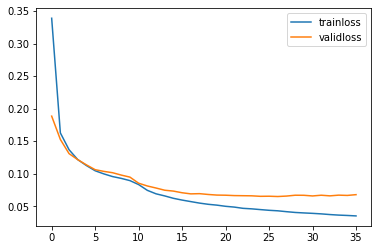

In [73]:
plt.plot(trainlosslist, label = "trainloss")
plt.plot(validlosslist, label = "validloss")
plt.legend()
plt.show()


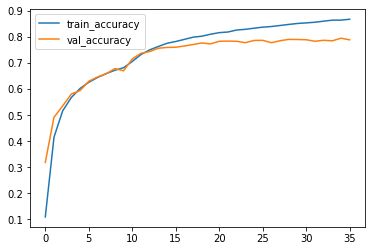

In [74]:
plt.plot(trainacclist, label = 'train_accuracy')
plt.plot(valacclist, label = 'val_accuracy')
plt.legend()
plt.show()

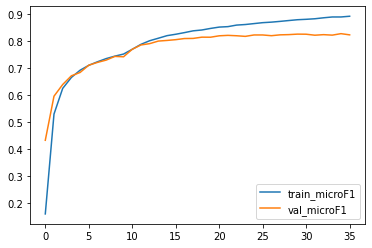

In [75]:
plt.plot(trainmicrof1list, label = 'train_microF1')
plt.plot(valmicrof1list, label = 'val_microF1')
plt.legend()
plt.show()

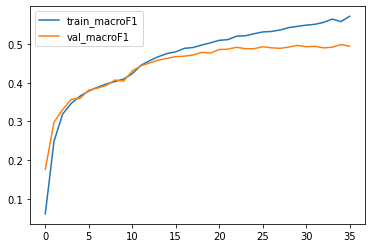

In [76]:
plt.plot(trainmacrof1list, label = 'train_macroF1')
plt.plot(valmacrof1list, label = 'val_macroF1')
plt.legend()
plt.show()

In [77]:
#make id2tag
id2tag = {}
for tag in nertags.keys():
    if(tag == 'padtag'):
        id2tag[nertags[tag]] = 'O' # because we dont want the model to predict 'padtag' tags
    else:
        id2tag[nertags[tag]] = tag

# print(id2tag)

In [78]:
def final_metrics(model, loader):
    y_predicted = []
    y_true = []
    with torch.no_grad():
        for step, (X, Xchar, Y, xlen, xlen_char) in enumerate(loader):
            Y = pack_padded_sequence(Y, xlen, batch_first=True, enforce_sorted=False)
            Y, _ = pad_packed_sequence(Y, batch_first=True)
            ypred = model(X.long().to(device), Xchar.to(device), xlen.to(device), xlen_char.to(device))#.permute(0, 2, 1)
            ypred = torch.argmax(ypred.to('cpu'), dim = 1)
            ypred = ypred.view(Y.shape[0], -1)
            # print(ypred.shape)

            y_predicted.append(ypred)
            y_true.append(Y)

    y_predicted_list = []
    y_true_list = []
    for i in range(len(y_predicted)):
        for j in range(y_predicted[i].shape[0]):
            sent_pred = []
            sent_true = []
            for x in range(y_predicted[i].shape[1]):
                sent_pred.append(id2tag[int(y_predicted[i][j, x])])
                sent_true.append(id2tag[int(y_true[i][j, x])])
            y_predicted_list.append(sent_pred)
            y_true_list.append(sent_true)
    print(y_predicted_list[0:5])
    print(y_true_list[0:5])
    return seq_f1_score(y_true_list, y_predicted_list), seq_accuracy_score(y_true_list, y_predicted_list), seq_classification_report(y_true_list, y_predicted_list)
    #CONVERTING y_predicted and y_true lists into tag list
    # return y_predicted, y_true

In [80]:
# calculate the final metrics usign seq eval
# TRAINING DATA
loader_train = DataLoader(traindataset, batch_size= 1, shuffle=False)
train_f1_conll, train_acc_conll, train_classif_report = final_metrics(model, loader_train)

# VALIDATION DATA
loader_valid = DataLoader(devdataset, batch_size= 1, shuffle=False)
valid_f1_conll, valid_acc_conll, valid_classif_report = final_metrics(model, loader_valid)

[['O', 'B-org', 'O', 'O', 'O', 'B-tim', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'B-org', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'B-tim', 'O', 'B-geo', 'O', 'B-geo', 'B-per', 'I-per', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']]
[['O', 'B-org', 'O', 'O', 'O', 'B-tim', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'B-geo'

In [81]:
print(train_f1_conll, train_acc_conll)
print(valid_f1_conll, valid_acc_conll)
print(train_classif_report)
print(valid_classif_report)

0.8454516767549269 0.9753905832291655
0.7636627710599203 0.9568450895810924
              precision    recall  f1-score   support

         art       0.47      0.35      0.40       296
         eve       0.42      0.42      0.42       226
         geo       0.86      0.90      0.88     29240
         gpe       0.94      0.93      0.94     12058
         nat       0.57      0.45      0.50       133
         org       0.70      0.70      0.70     15803
         per       0.85      0.84      0.84     13121
         tim       0.89      0.87      0.88     15767

   micro avg       0.84      0.85      0.85     86644
   macro avg       0.71      0.68      0.70     86644
weighted avg       0.84      0.85      0.85     86644

              precision    recall  f1-score   support

         art       0.29      0.13      0.18       105
         eve       0.34      0.26      0.29        78
         geo       0.80      0.84      0.82      9724
         gpe       0.91      0.91      0.91      4210
  

In [82]:
#save train loss, acc, micro, macro
#save val loss, acc, micro, macro
#save figure train, val - loss, acc, micro, macro
#save the sentence level f1 score evaluation which is done using seq eval
# save model

In [83]:
testdatapath = "/content/drive/MyDrive/Q2_DL/test.txt"

char_vocab = get_charvocab(vocab)
Xtest, Ytest, x_testlengths, _, _ = load_data(testdatapath, buildvocab_tags=False, vocab = vocab, nertags = nertags)

Xtest_temp, Ytest_temp, x_testlengths_temp, testvocab, testnertags = load_data(testdatapath, buildvocab_tags=True)
wordid2word_charlevel_vocab_test, wordid2wordlen_test = make_id2word_charvocab(testvocab, char_vocab) # of the form {word:[1,2,3,4]}, {wordnum:wordlen}
#make char level train data for the char embeddings 
Xtest_char, xtestlength_char = load_char_level(Xtest_temp, wordid2word_charlevel_vocab_test, wordid2wordlen_test)
#finally make the dataloader for train
testdataset = TensorDataset(Xtest, Xtest_char, Ytest, x_testlengths, xtestlength_char)
loader_test = DataLoader(testdataset, batch_size= 1, shuffle=False)

24


In [84]:
test_f1_conll, test_acc_conll, test_classif_report = final_metrics(model, loader_test)

[['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['B-gpe', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-tim', 'O', 'B-geo', 'O'], ['B-per', 'I-per', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-tim', 'O', 'O', 'O', 'O', 'O', 'O', 'O']]
[['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['B-gpe', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-tim', '

In [85]:
print(test_f1_conll, test_acc_conll)
print(test_classif_report)

0.7601134247218911 0.955933057058525
              precision    recall  f1-score   support

         art       0.20      0.08      0.11       102
         eve       0.32      0.28      0.30        87
         geo       0.80      0.84      0.82      9912
         gpe       0.91      0.90      0.91      4168
         nat       0.55      0.42      0.47        55
         org       0.49      0.58      0.54      5205
         per       0.71      0.70      0.70      4406
         tim       0.84      0.82      0.83      5275

   micro avg       0.75      0.78      0.76     29210
   macro avg       0.60      0.58      0.59     29210
weighted avg       0.75      0.78      0.76     29210



In [86]:
print(Xtest_char[0, 1])
print(char_vocab)

tensor([23, 32, 66,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0])
{'<padchar>': 0, '<oovchar>': 1, 'e': 2, 'k': 3, 'z': 4, "'": 5, 'x': 6, 'r': 7, '[': 8, ']': 9, '~': 10, 'j': 11, 'i': 12, '7': 13, 'l': 14, '9': 15, '6': 16, '#': 17, '…': 18, 'o': 19, 'é': 20, 'v': 21, '&': 22, 's': 23, '8': 24, 'w': 25, '’': 26, '–': 27, '/': 28, '?': 29, '"': 30, 'm': 31, 'a': 32, '3': 33, '0': 34, 'u': 35, '-': 36, ',': 37, '”': 38, ':': 39, 'ö': 40, '(': 41, 'g': 42, '`': 43, '5': 44, 'f': 45, '—': 46, '‘': 47, '.': 48, 'n': 49, '_': 50, 'ó': 51, '2': 52, 'c': 53, '$': 54, '>': 55, '4': 56, 'b': 57, ';': 58, ')': 59, 'p': 60, 'h': 61, '1': 62, '%': 63, '!': 64, 'd': 65, 'y': 66, 'q': 67, 't': 68, '“': 69, '<': 70}


In [87]:
print(Ytest)

tensor([[ 6.,  6.,  6.,  ...,  0.,  0.,  0.],
        [14.,  6.,  6.,  ...,  0.,  0.,  0.],
        [ 6.,  6.,  6.,  ...,  0.,  0.,  0.],
        ...,
        [ 6.,  6.,  6.,  ...,  0.,  0.,  0.],
        [ 6.,  6.,  6.,  ...,  0.,  0.,  0.],
        [ 6.,  6.,  6.,  ...,  0.,  0.,  0.]])


In [88]:
print(Xdev.shape)

torch.Size([12402, 68])


In [89]:
!head "/content/drive/MyDrive/Q2_DL/test.txt"



it PRP It O
say VBD said O
the DT the O
fund NNS funds O
would MD would O
also RB also O
be VB be O
use VBN used O
for IN for O
